In [60]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns
import datetime
from networkx import NetworkXNoPath

# import custom functions
from corrmat_functions import *

# Load all networks

In [61]:
# load all networks
msts = np.load('data/msts.npy', allow_pickle='TRUE').item()  # MSTs
pmfgs = np.load('data/pmfgs.npy', allow_pickle='TRUE').item()  # PMFGs
tns = np.load("data/tns.npy", allow_pickle="TRUE").item()  # Threshold networks TNs

In [62]:
# #changing pmfgs so it has the same layout as msts and tns

# #setting tickers as node attributes for pmfgs
# for i, (k,pmfg) in enumerate(sorted(pmfgs.items())):
#     tickers = {index: stockname for index, stockname in enumerate(pmfg['ticker'])}
#     nx.set_node_attributes(pmfg['network'], tickers , 'ticker')

# #changing dictionary structure to { <timestamp> : <pmfg> }
# pmfgs = {k:v['network'] for k,v in pmfgs.items()}

In [63]:
#properties to consider
# https://www.sciencedirect.com/science/article/pii/S2214845020300521
# Nodes	Avg.Degree	Pathlength	Betweenness Centrality	Closeness Centrality	Power Law p(k) ∼ k−    

# https://link.springer.com/article/10.1007/s10614-016-9627-7
# normalized tree length  
# average path length
# mean occupation layer


#https://link.springer.com/chapter/10.1007/978-3-030-66046-8_21
# centrality measures per node compared over time
# Degree Centrality
# Node Strength
# Betweenness Centrality
# Closeness Centrality
# Eigenvector Centrality

In [64]:
test_date = '2020-05-13 01-00-00'
mst_test = msts[test_date]
# print(sorted(msts.keys()))

In [65]:
def str_to_date(string):
    return datetime.datetime.strptime(string, "%Y-%m-%d %H-%M-%S")

# Generic function to plot metrics over time

In [66]:
def mean_occupation_layer(G):
    N = G.number_of_nodes()
    
    #get the node with max degree
    max_degree_id = max(dict(G.degree()), key=dict(G.degree()).get)

    #shortest path length from source (which is node whith highest degree) and all other nodes
    level_to_central = nx.single_source_shortest_path_length(G, max_degree_id).values()

    return (1/N) * sum(level_to_central)

In [67]:
def compare_networks(MSTs, PMFGs, TNs, measure, title, weighted=False, net_size=False, mol=False):
    """
    MSTs, PMFGs and TNs are dictionaries of networks where keys are strings timestamps and values are networkx graphs.
    measure: networkx function, e.g. nx.average_shortest_path_length(G)
    weighted: set True to use networkx argument weight="weight"
    Set MSTs, PMFGs or TNs = None to not consider those for the measure
    net_size: True to superimpose network size (i.e. nr of nodes)
    net_size: True to superimpose mean occupation layer
    title: title of the plot
    returns a plot
    """
    dates_strings = sorted(msts.keys())
    dates = [str_to_date(i) for i in dates_strings]

    few_data = ["2020-09-30 01-00-00", "2020-10-07 01-00-00"]

    # compute measures for all graphs
    m_msts = []
    m_pmfgs = []
    m_tns = []
    for t in dates_strings:
        if t in few_data:
            m_msts.append(np.nan)
            m_pmfgs.append(np.nan)
            m_tns.append(np.nan)
        else:
            if MSTs is not None:
                if weighted:
                    m_msts.append(measure(MSTs[t], weight="weight"))
                else:
                    m_msts.append(measure(MSTs[t]))
            if PMFGs is not None:
                if weighted:
                    m_pmfgs.append(measure(PMFGs[t], weight="weight"))
                else:
                    m_pmfgs.append(measure(PMFGs[t]))
            if TNs is not None:
                if weighted:
                    m_tns.append(measure(TNs[t], weight="weight"))
                else:
                    m_tns.append(measure(TNs[t]))

    # plot parameters
    fs = 13  # fontsize

    # plot measures
    fig, ax = plt.subplots(1,1, figsize=(12,7), constrained_layout=True)
    if MSTs is not None:
        ax.plot(dates, m_msts, label="MST")
    if PMFGs is not None:
        ax.plot(dates, m_pmfgs, label="PMFG")
    if TNs is not None:
        ax.plot(dates, m_tns, label="TN")
    
    # superimpose network size
    if net_size:
        net_size_ = [MSTs[t].number_of_nodes() for t in dates_strings]
        ax.plot(dates, net_size_, label="Network Size", color="purple", linestyle="--")
    # superimpose mean occupation layer
    if mol:
        mol_ = [mean_occupation_layer(MSTs[i]) for i in dates_strings]
        for i,t in enumerate(dates_strings): 
            if t in few_data:
                mol_[i] = np.nan
        ax.plot(dates, mol_, label="Mean Occupation Layer (MST)", color="gray", linestyle="--")

    # mark important dates in the figure

    # too few data available
    # few_data = [str_to_date("2020-09-30 01-00-00"), str_to_date("2020-10-07 01-00-00")]
    # ax.axvspan(few_data[0], few_data[1], color='gray', alpha=0.3, lw=0, label="too few data points")

    # stock market crash (dates according to wikipedia: https://en.wikipedia.org/wiki/2020_stock_market_crash)
    crash = [datetime.date(2020, 2, 20), datetime.date(2020, 7, 4)]
    ax.axvspan(crash[0], crash[1], color='red', alpha=0.3, lw=0, label="stock market crash")

    ax.legend(fontsize=fs)
    ax.set_xlabel("date", fontsize=fs)
    ax.tick_params(axis='x', labelsize=fs)
    ax.tick_params(axis='y', labelsize=fs)
    fig.suptitle(title, fontsize=fs+5)
    fig.savefig(f"figures/metrics_{title}.png")

## Degree related metrics
- Max Degree
- Average Degree
- Density
- Assortativity
- Nearest Neighbor Degree

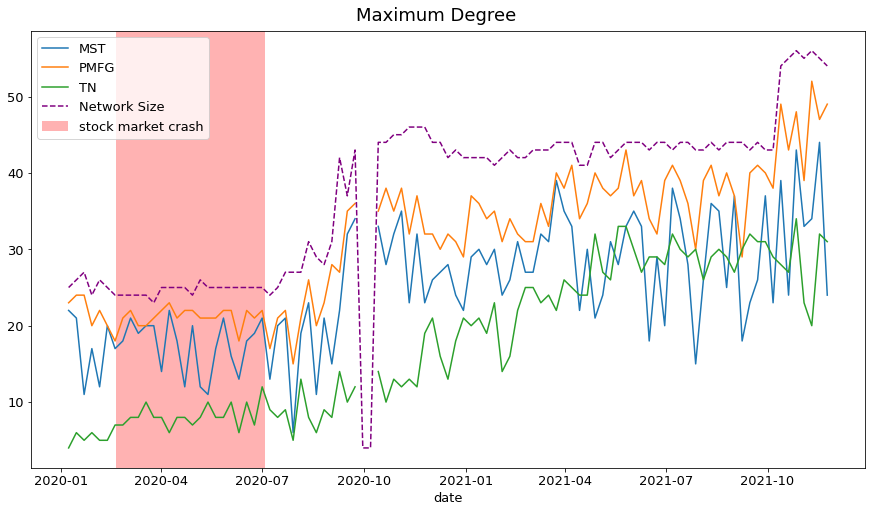

In [68]:
max_deg = lambda G: np.max([j for i,j in G.degree()])
compare_networks(msts, pmfgs, tns, max_deg, "Maximum Degree", net_size=True)

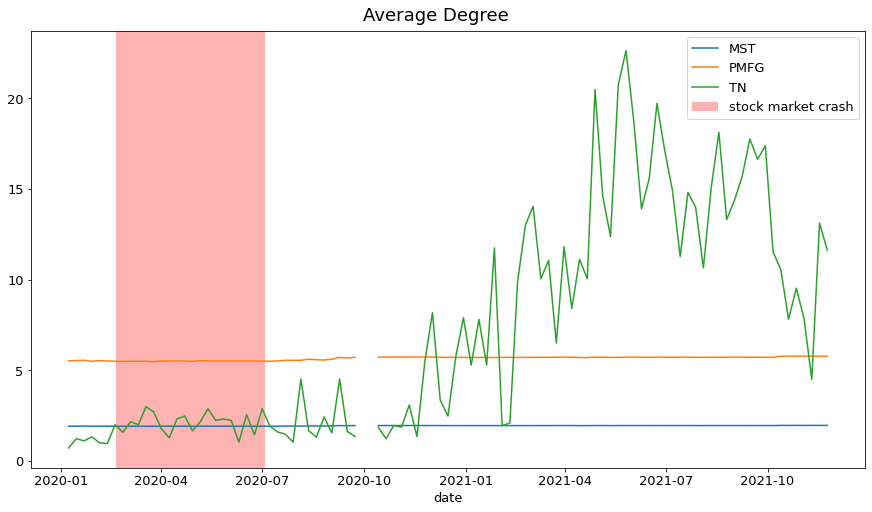

In [69]:
avg_deg = lambda G: np.mean([j for i,j in G.degree()])
compare_networks(msts, pmfgs, tns, avg_deg, "Average Degree")

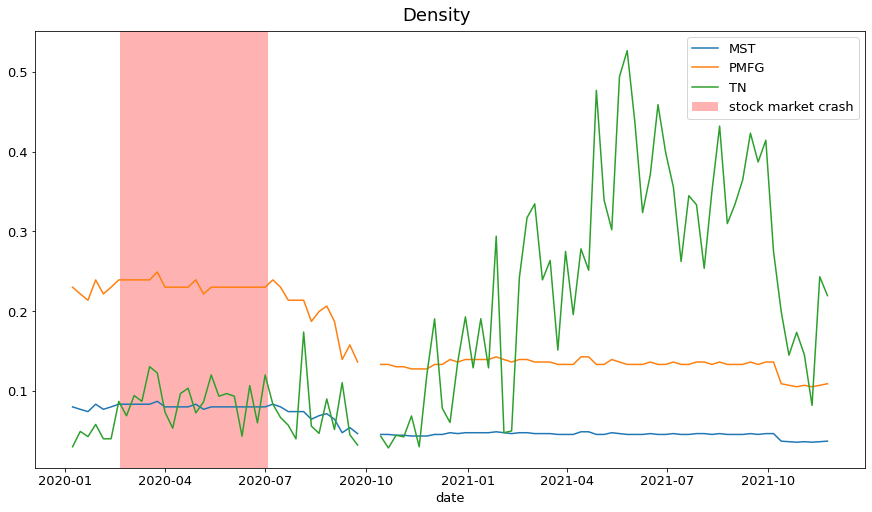

In [70]:
compare_networks(msts, pmfgs, tns, nx.density, "Density")

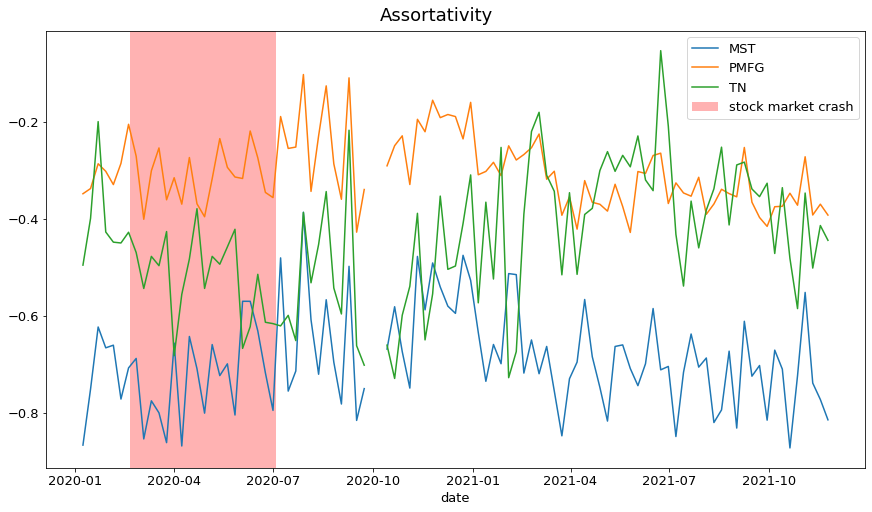

In [71]:
compare_networks(msts, pmfgs, tns, nx.degree_assortativity_coefficient, "Assortativity", weighted=True)

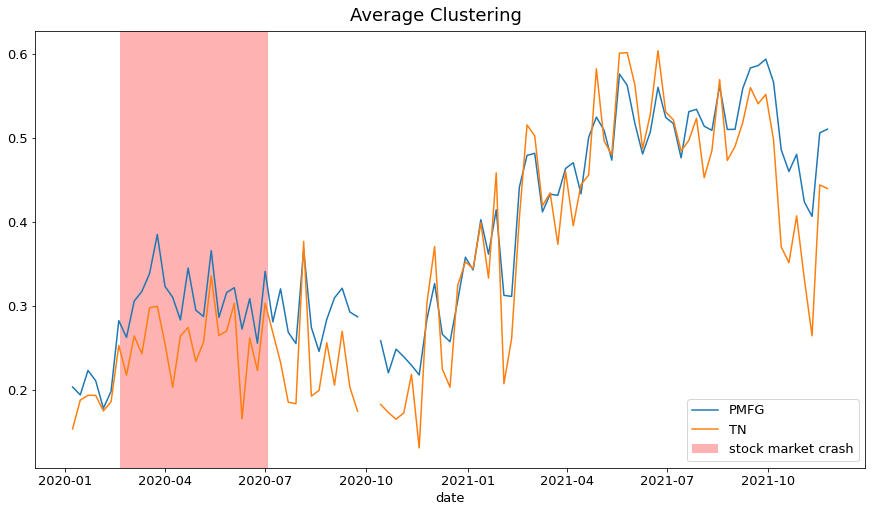

In [72]:
compare_networks(None, pmfgs, tns, nx.average_clustering, "Average Clustering", weighted=True)

## Distance Based
computed using unweighted graphs, i.e. consider all edges to have weight 1. this is because the PMFG contains some negative weights, due to negative correlations and therefore the networkx algorithms nx.all_pairs_bellman_ford_path_length and nx.all_pairs_dijkstra_path_length can not be computed.
- Average Distance
- Diameter

In [73]:
for i in pmfgs.keys():
    a = nx.to_numpy_array(pmfgs[i])
    print(i, np.min(a))

2021-09-22 01-00-00 0.0
2021-03-24 01-00-00 -0.00478374162440606
2020-05-13 01-00-00 0.0
2020-12-23 01-00-00 0.0
2020-07-15 01-00-00 -0.003603991920678904
2021-04-21 01-00-00 -0.002492837356837518
2020-06-03 01-00-00 0.0
2020-08-05 01-00-00 0.0
2020-05-27 01-00-00 -0.004161828712976346
2021-06-16 01-00-00 0.0
2020-06-17 01-00-00 -0.0007825223415443458
2021-05-19 01-00-00 0.0
2020-08-19 01-00-00 0.0
2021-03-10 01-00-00 0.0
2020-03-04 01-00-00 -0.0038389803216855403
2020-11-18 01-00-00 -0.0026302136974700793
2020-05-06 01-00-00 0.0
2020-02-12 01-00-00 -0.0001049842346812077
2020-01-15 01-00-00 0.0
2021-05-12 01-00-00 -0.004089714743147339
2021-07-07 01-00-00 0.0
2021-03-31 01-00-00 0.0
2020-09-23 01-00-00 0.0
2021-07-21 01-00-00 -0.0009439126046149389
2021-11-17 01-00-00 0.0
2021-10-27 01-00-00 0.0
2021-06-23 01-00-00 -0.0008073419515527649
2020-09-09 01-00-00 0.0
2021-07-14 01-00-00 0.0
2020-12-30 01-00-00 0.0
2020-10-28 01-00-00 -0.0026984840363850995
2021-02-17 01-00-00 0.0
2020-10-07

In [74]:
def distance(G):
    """returns a matrix of the pairwise distances. If no path, then set to infinity."""
    # A = nx.to_numpy_array(G)
    # print(A)

    nodes = list(G.nodes())
    N = len(nodes)

    # initialize all distances as inf
    d = np.full((N, N), np.inf)

    # compute every pairwise distance (inf if not connected)
    for i, j_dict in nx.all_pairs_shortest_path_length(G):
        for j in j_dict.keys():
            d[i,j] = j_dict[j]

    return d


def inf_diameter(G):
    """return maximum distance that is not infinity."""
    d = distance(G)

    # get max of non inf values
    m = np.amax(d, where=~np.isinf(d), initial=0)
    return m


def avg_distance(G):
    d = distance(G)

    avg_d = np.mean(d, where=~np.isinf(d))
    return avg_d


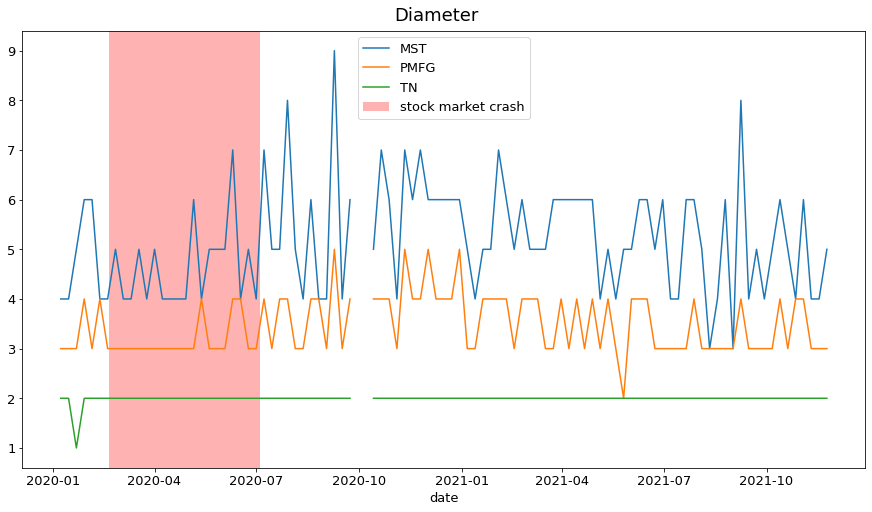

In [75]:
compare_networks(msts, pmfgs, tns, inf_diameter, "Diameter", False)

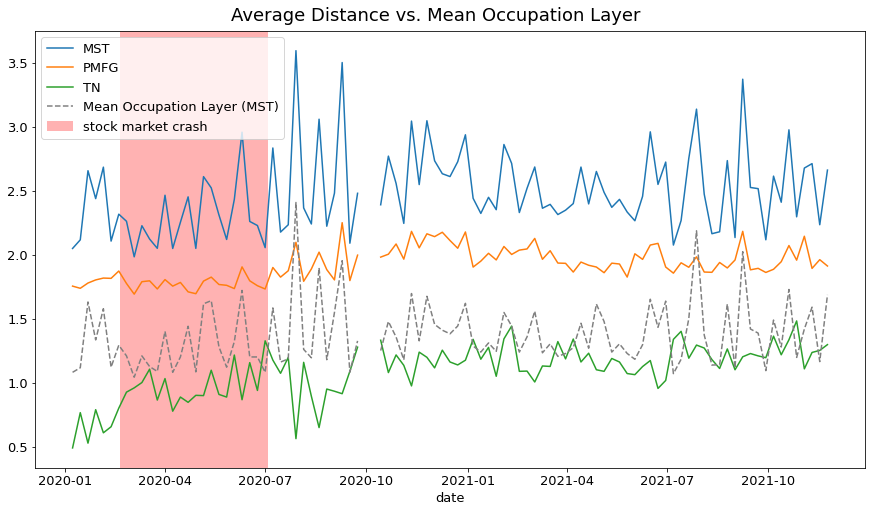

In [76]:
compare_networks(msts, pmfgs, tns, avg_distance, "Average Distance vs. Mean Occupation Layer", mol=True)

## Average Clustering

## Centrality
- average betweenness 
- average closeness

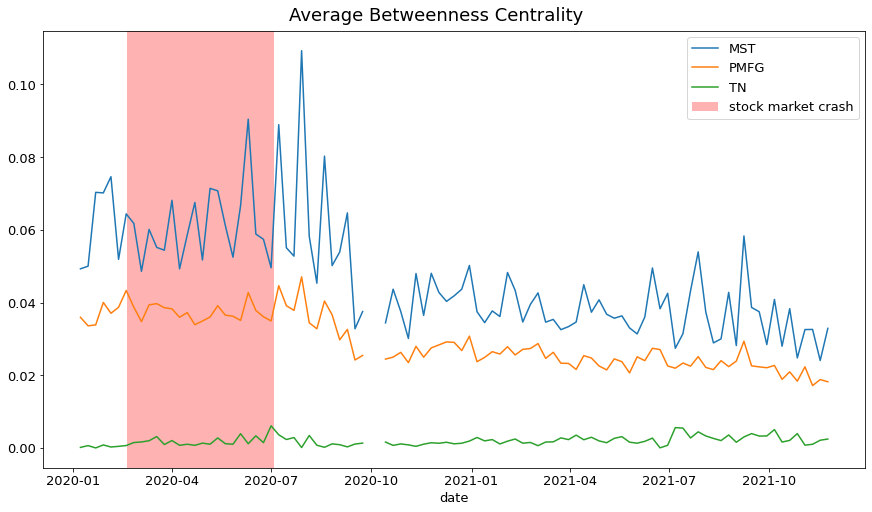

In [77]:
avg_between = lambda G: np.mean(list(nx.betweenness_centrality(G).values()))
compare_networks(msts, pmfgs, tns, avg_between, "Average Betweenness Centrality")

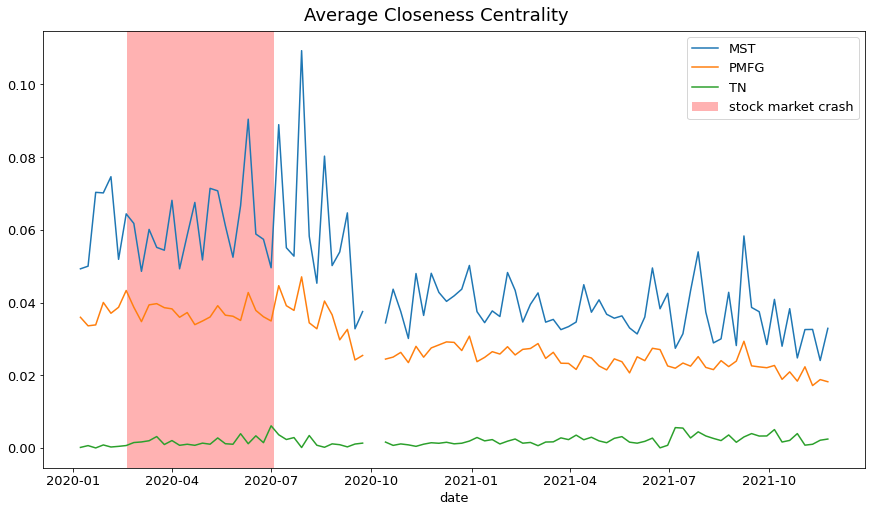

In [78]:
avg_closeness = lambda G: np.mean(list(nx.closeness_centrality(G).values()))
compare_networks(msts, pmfgs, tns, avg_between, "Average Closeness Centrality")

## Mean Occupation Layer

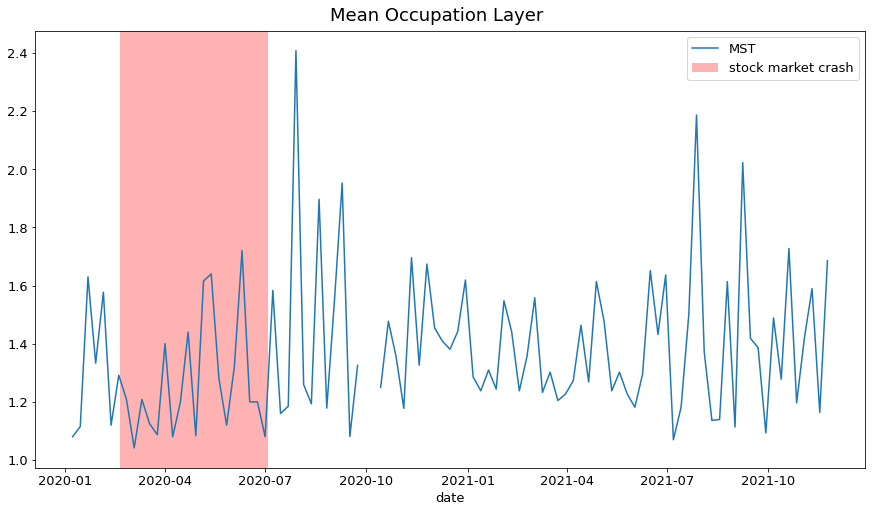

In [79]:
compare_networks(msts, None, None, mean_occupation_layer, "Mean Occupation Layer")

## Network Centrality Heatmaps

In [80]:
# takes dicionary as input with this structure
# { <timestamp> : <network> }
# it returns a dictionary with centralities at each timestamp
# centralities are saves ad a dictionary with each ticker as key
# {  <timestamp> : 
#           {
#               'degree_centrality' : 
#                       {
#                           'BTC' : <value>,
#                           'ETH' : <value>,  
#                              ..... 
#                       }
#               'betweenness_centrality' : 
#                       {
#                           'BTC' : <value>,
#                           'ETH' : <value>,  
#                              ..... 
#                       }
#                  ........
#           }
# }



def get_network_node_centralities(network_dict):

    network_properties = {}

    for k,G in sorted(network_dict.items()):
        properties = {}

        properties['nodes'] = G.number_of_nodes()
        properties['degree_centrality'] = dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.degree_centrality(G).values()))
        properties['betweenness_centrality'] = dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.betweenness_centrality(G).values()))
        properties['closeness_centrality'] =  dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.closeness_centrality(G).values()))
        properties['eigenvector_centrality'] = dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.eigenvector_centrality(G).values()))


        network_properties[k] = properties

    return network_properties


In [82]:
#takes dictionary generated by get_network_node_centralities() (see above for structure) and the centrality measure we want as string
#for example : get_centrality_df(msts_node_centralities, 'degree_centrality')
#and returns a pandas dataframe where rows are tickers and columns are timestamps with that centrality as the values

def get_centrality_df(node_centralites, centrality, n_tickers_to_plot=57):
    tickers = load_corrmat_tickers()
    centralities = {}

    for timestamp,v in node_centralites.items():
        timestamp = timestamp.split(" ")[0]
        centralities[timestamp] = {}
        for i,ticker in enumerate(tickers):
            if i > n_tickers_to_plot:
                continue
            if ticker in v[centrality].keys():
                centralities[timestamp][ticker] = v[centrality][ticker]
            else:
                centralities[timestamp][ticker] = None

    return pd.DataFrame.from_dict(centralities)


Text(0.5, 1.0, 'MSTs degree centralities')

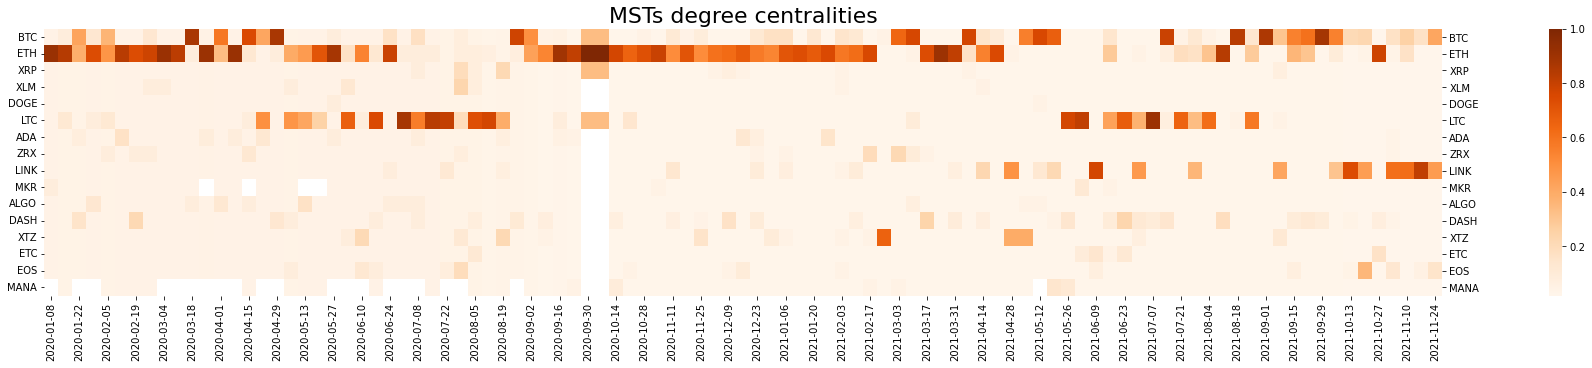

In [83]:
node_centralities = get_network_node_centralities(msts)

fig, ax = plt.subplots(1, figsize=(22,5) , constrained_layout=True)

df = get_centrality_df(node_centralities, 'degree_centrality',15)
mask = df.isnull()
ax = sns.heatmap(df, mask=mask, ax=ax, cmap="Oranges")
ax.tick_params('y', right=True, labelright=True, rotation=0)
ax.set_title('MSTs degree centralities', fontsize=22)

In [84]:
def plot_centrality_heatmaps(networks_list, names):
    for i, networks in enumerate(networks_list):

        node_centralities = get_network_node_centralities(networks)

        fig, axs = plt.subplots(4, figsize=(22,50) , constrained_layout=True)

        df = get_centrality_df(node_centralities, 'degree_centrality')
        mask = df.isnull()
        sns.heatmap(df, mask=mask, ax=axs[0], cmap="Oranges")
        axs[0].set_title('degree_centralities')

        df = get_centrality_df(node_centralities, 'betweenness_centrality')
        mask = df.isnull()
        sns.heatmap(df, mask=mask, ax=axs[1], cmap="Oranges")
        axs[1].set_title('betweenness_centrality')

        df = get_centrality_df(node_centralities, 'closeness_centrality')
        mask = df.isnull()
        sns.heatmap(df, mask=mask, ax=axs[2], cmap="Oranges")
        axs[2].set_title('closeness_centrality')

        df = get_centrality_df(node_centralities, 'eigenvector_centrality')
        mask = df.isnull()
        sns.heatmap(df, mask=mask, ax=axs[3], cmap="Oranges")
        axs[3].set_title('eigenvector_centrality')

        fig.suptitle("" + names[i] + " centralities over time", fontsize=25)

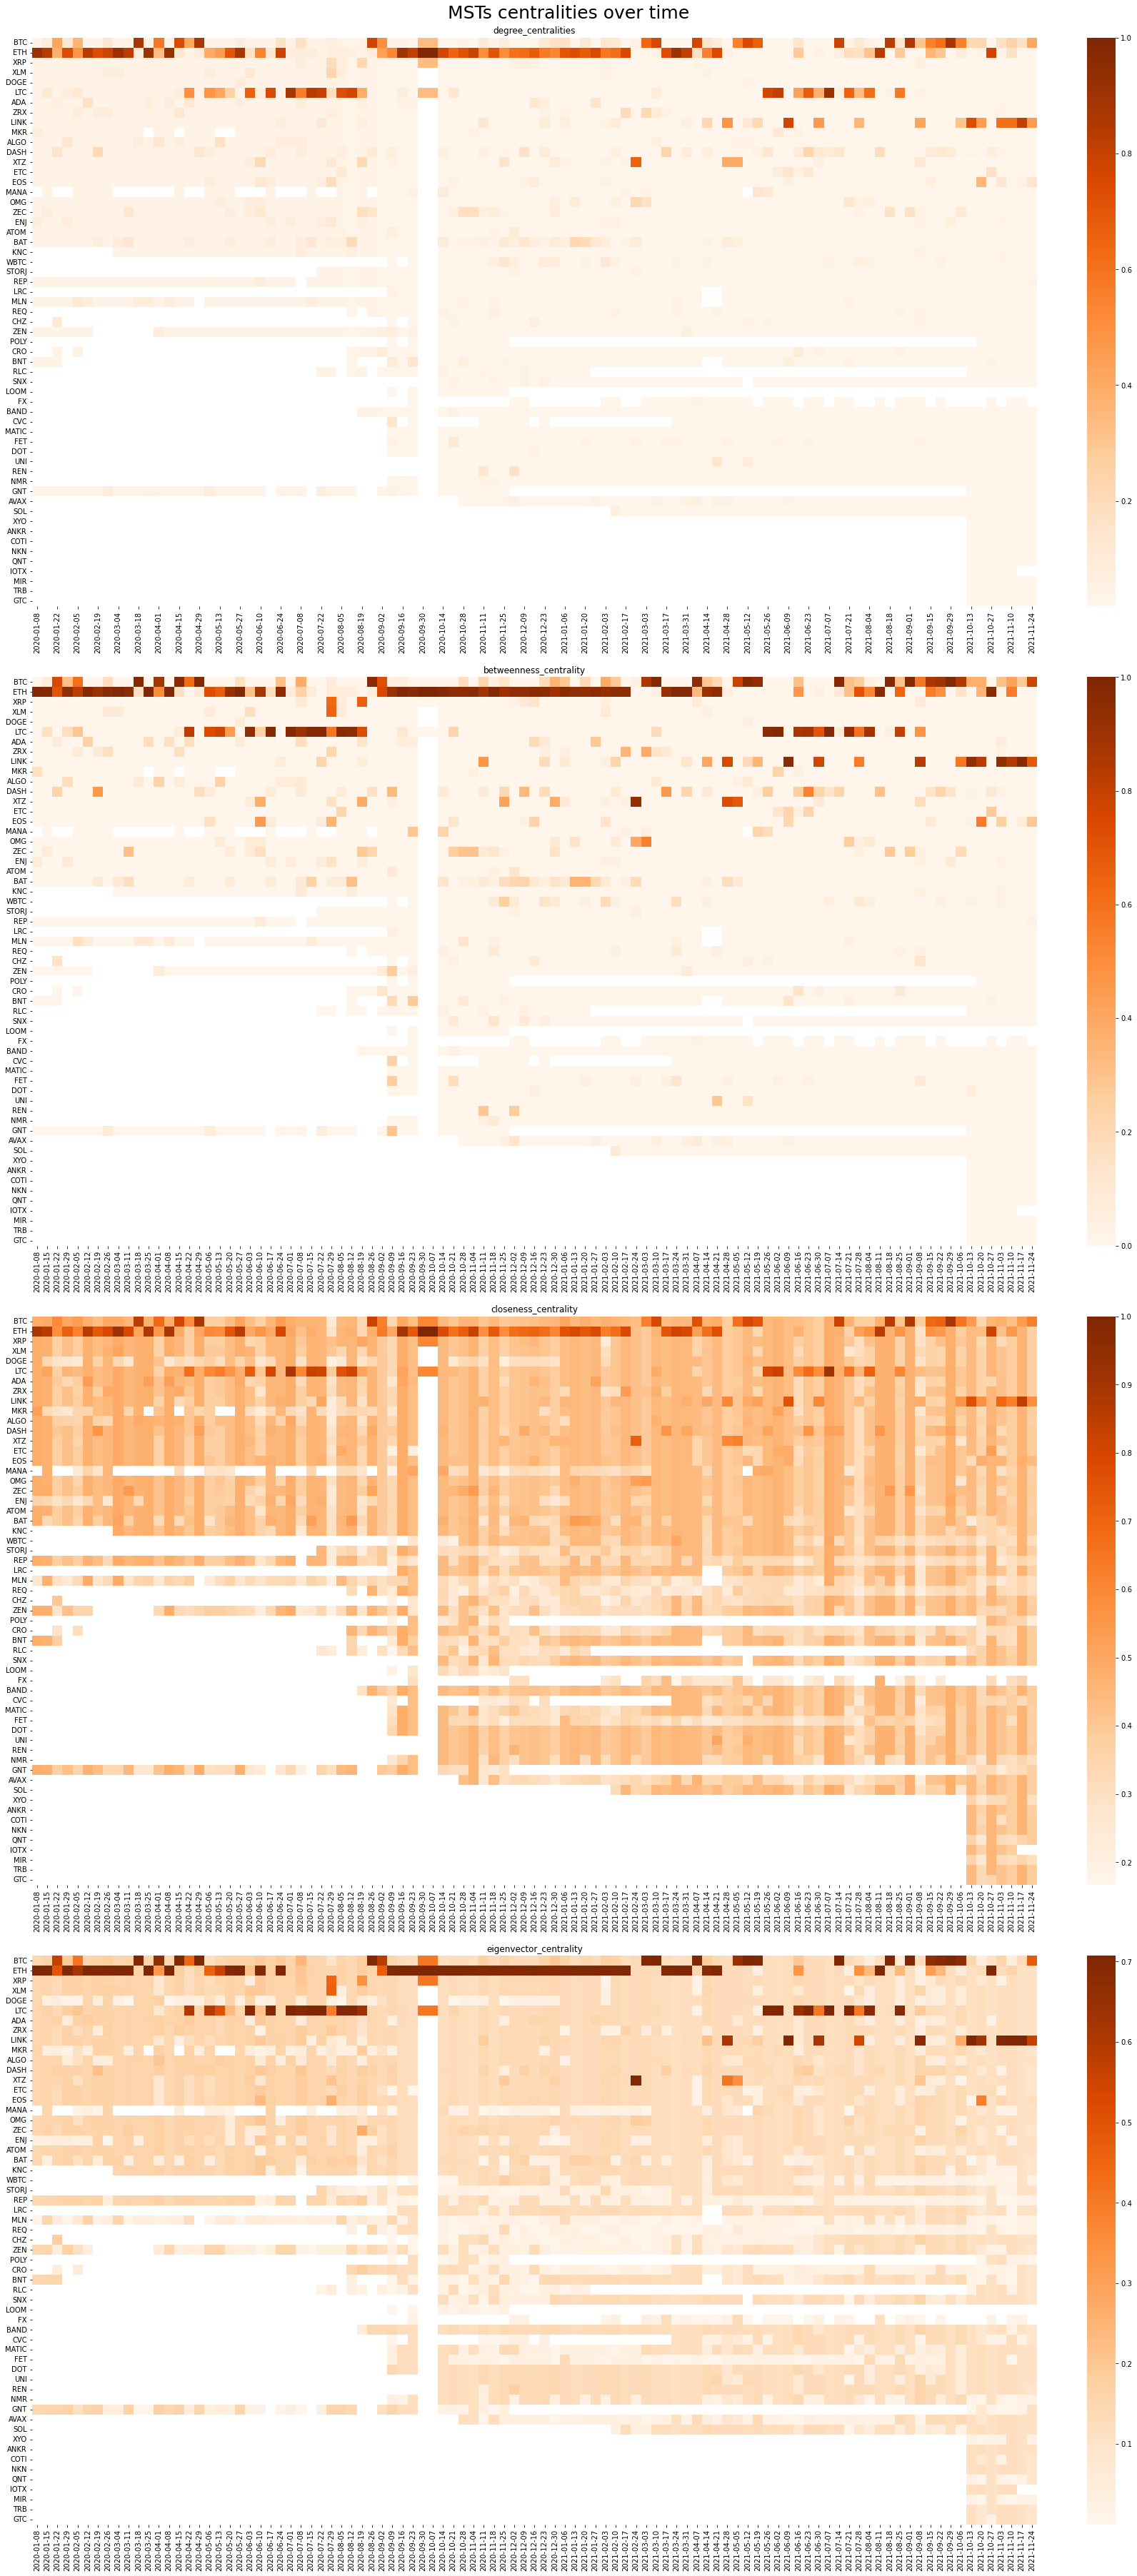

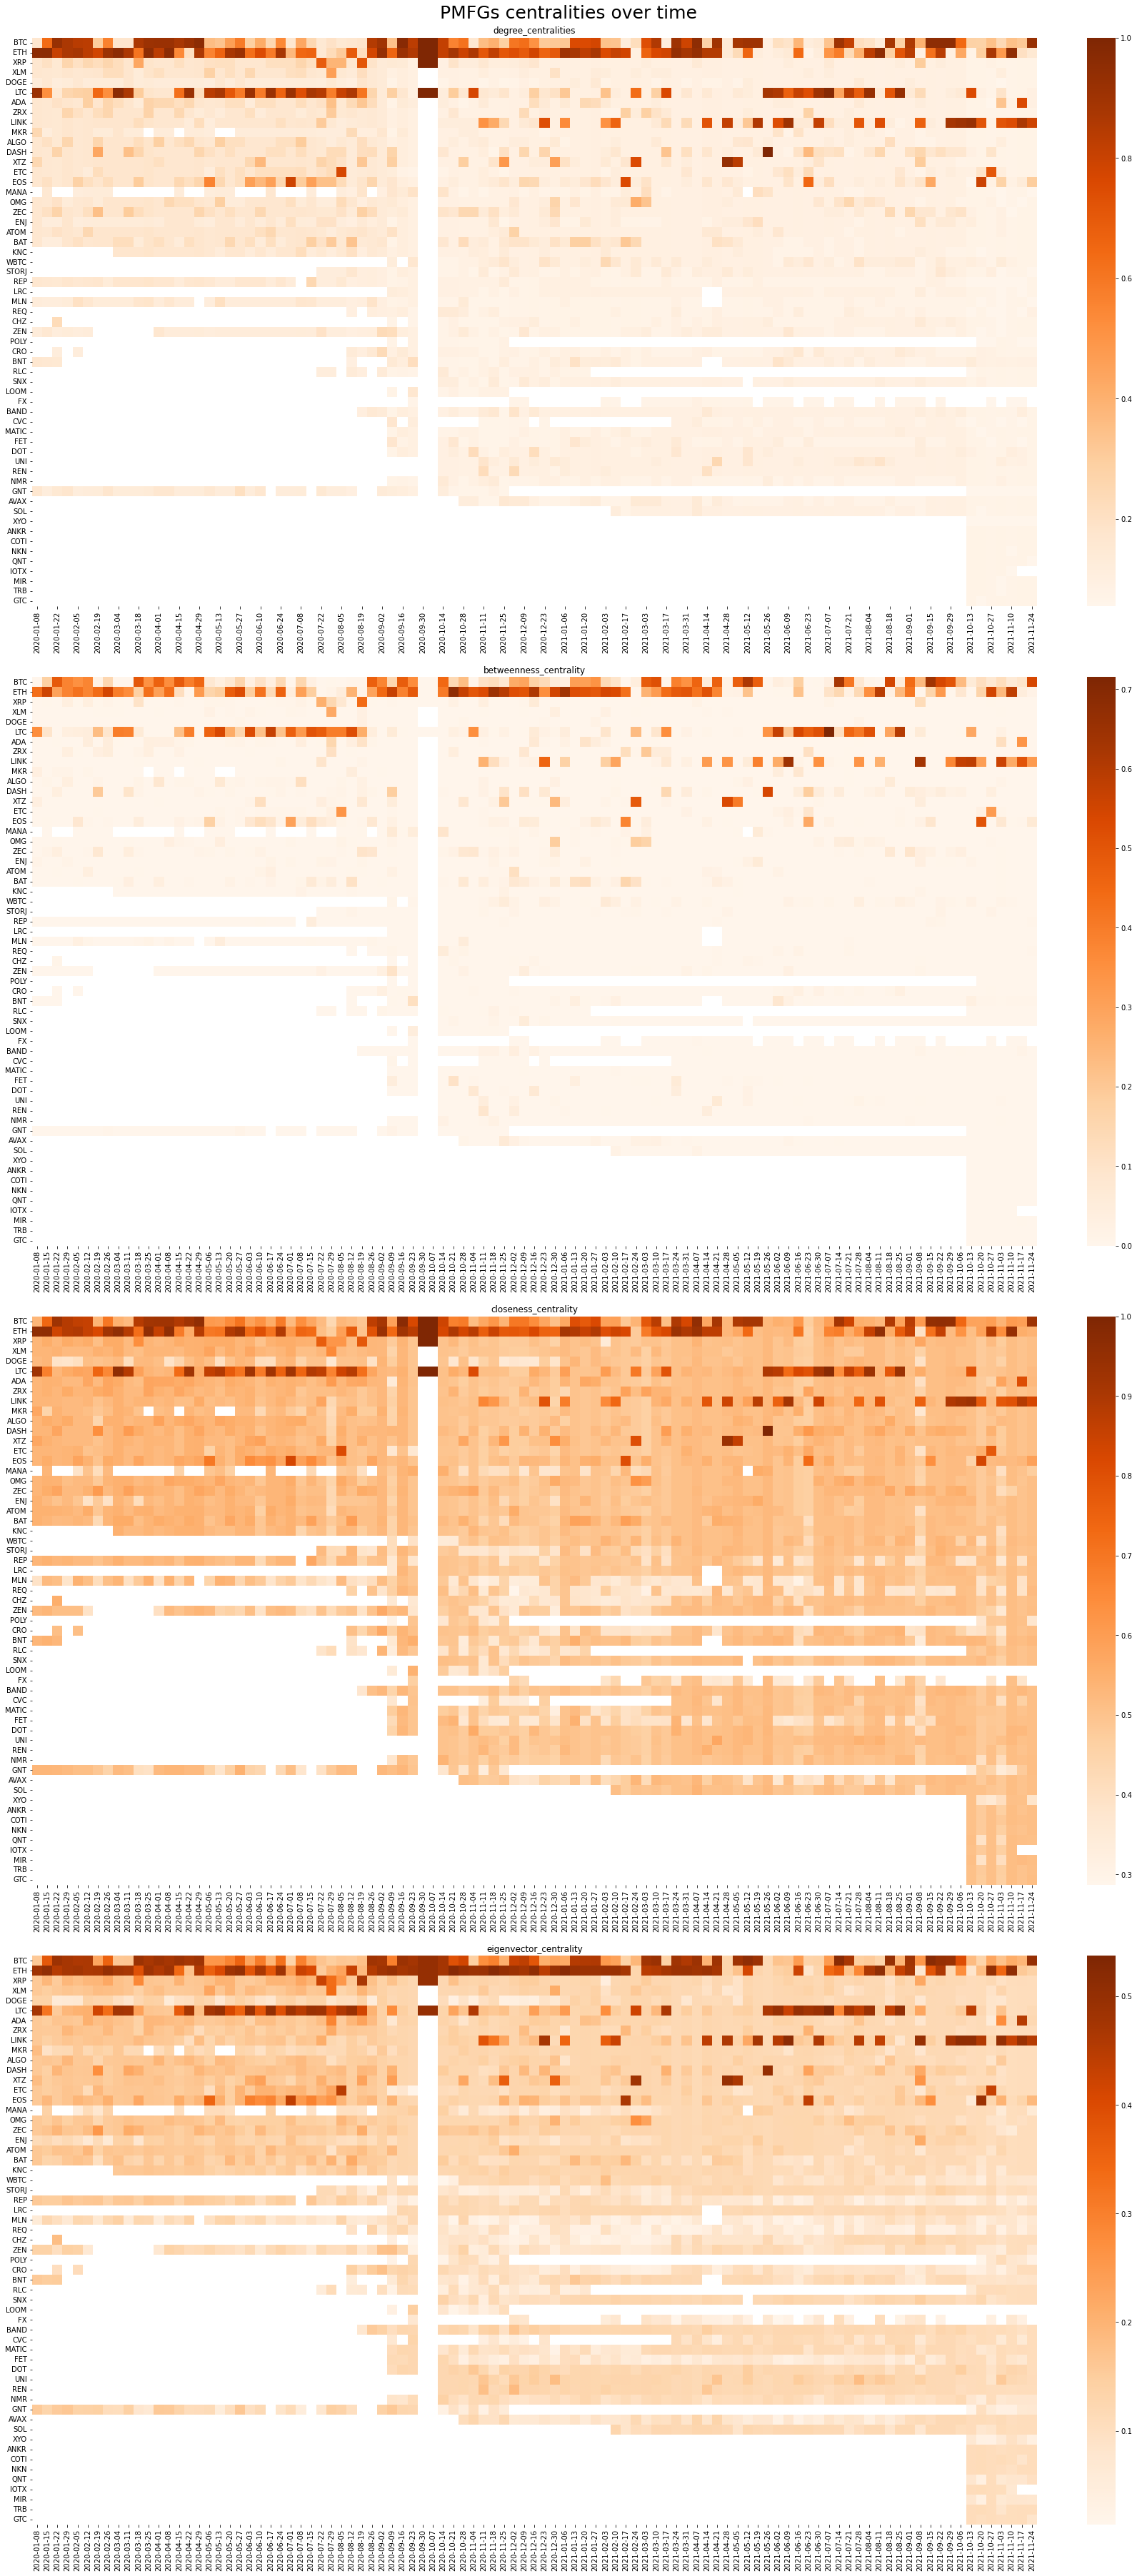

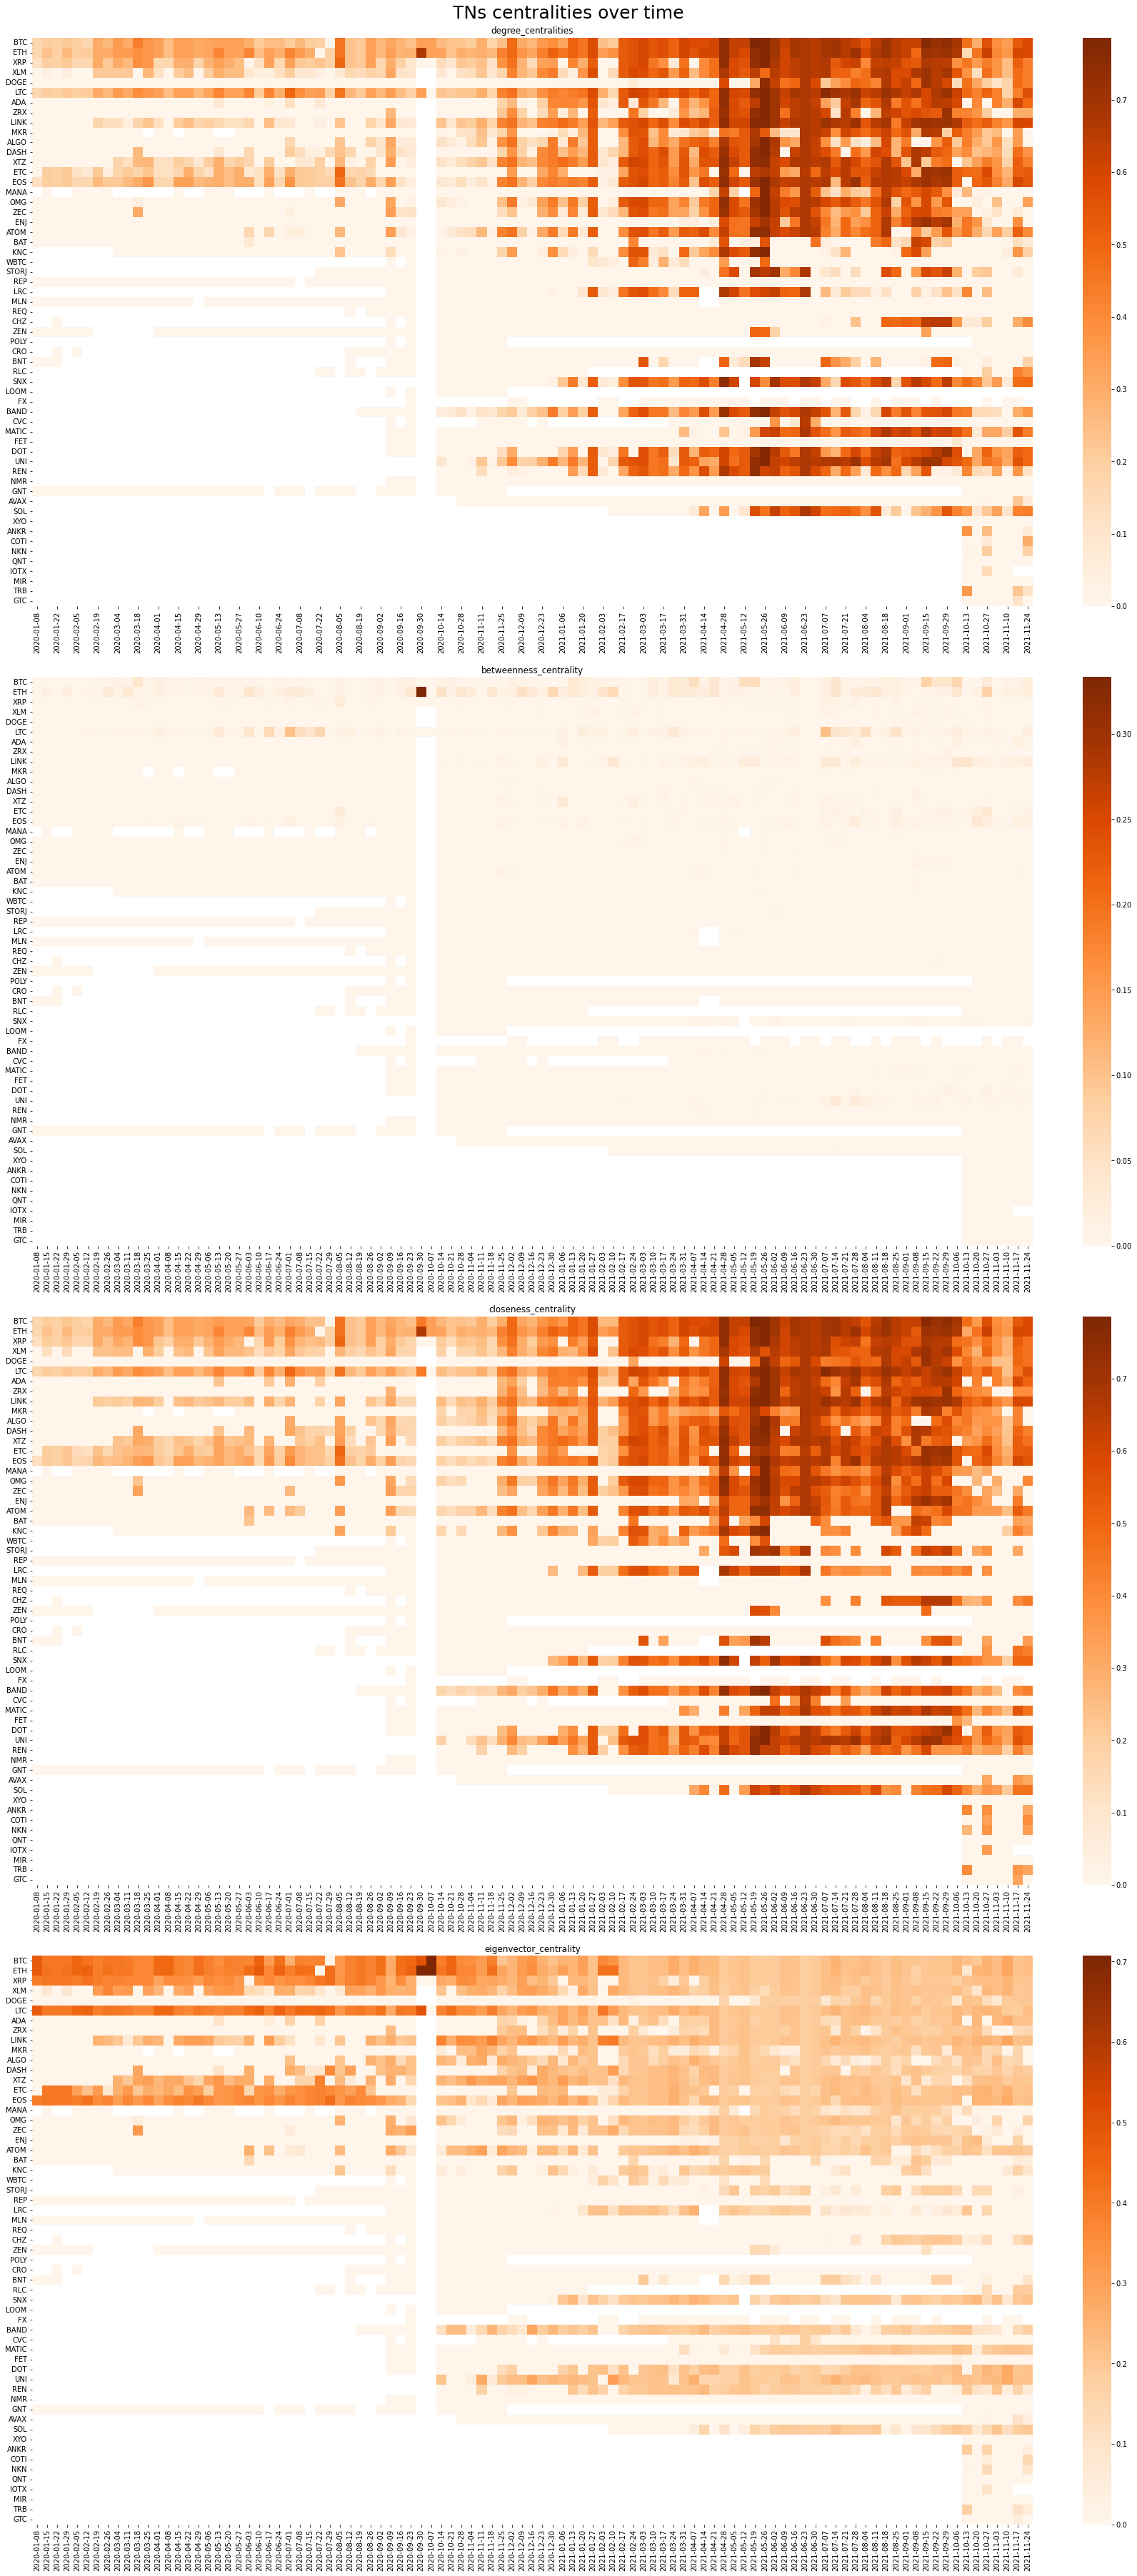

In [85]:
plot_centrality_heatmaps([msts,pmfgs,tns], ["MSTs", "PMFGs", "TNs"])

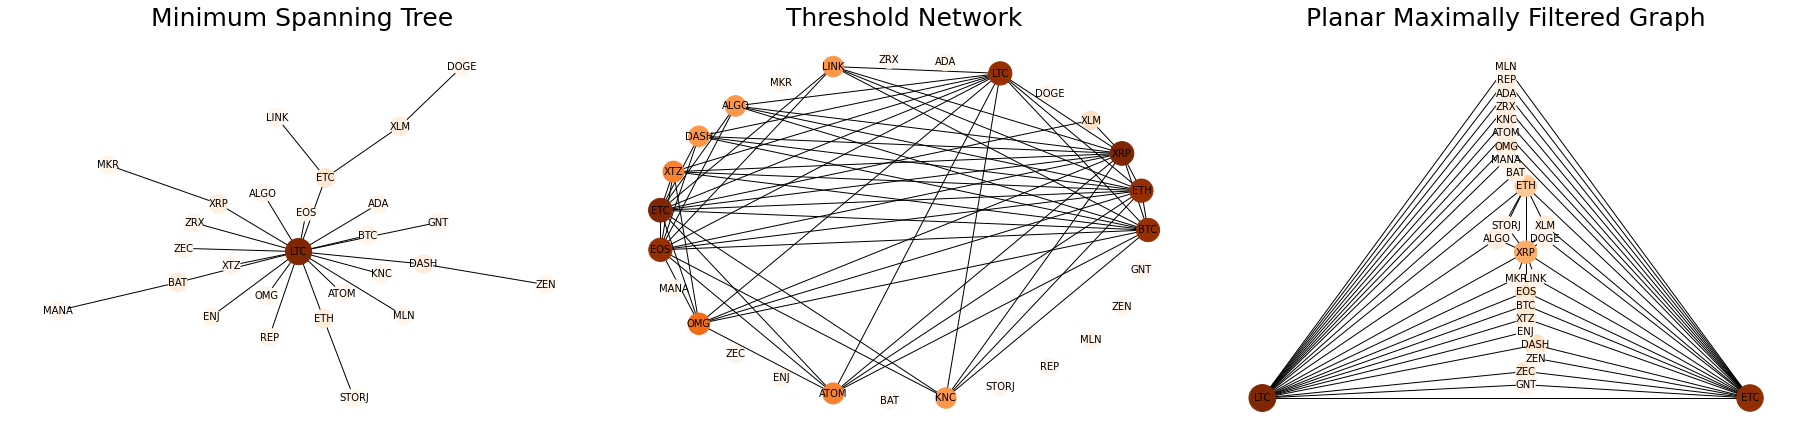

In [93]:
test_date = '2020-08-05 01-00-00'
networks = np.array([msts, tns, pmfgs])
fig, axs = plt.subplots(1, 3, figsize = (25, 6), constrained_layout = True)
pos_list = [nx.kamada_kawai_layout, nx.circular_layout, nx.planar_layout]
title_list = ['Minimum Spanning Tree', 'Threshold Network', 'Planar Maximally Filtered Graph']
for i in range(3):
    # if i == 2:
    #     test_date = '2020-09-09 01-00-00'
    mst = networks[i][test_date]
    node_color = [nx.degree(mst)[n] for n in nx.nodes(mst)]
    node_size = [300 + nx.degree(mst)[n] * 20 for n in nx.nodes(mst)]
    pos= pos_list[i](mst)
    nx.draw(mst, pos, ax = axs[i], node_color=node_color, cmap='Oranges', labels=nx.get_node_attributes(mst, 'ticker'), with_labels=True, node_size=node_size, font_size=10)
    axs[i].set_title(title_list[i], fontsize = 25)